## **4. Risk sensitive LQR**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.linalg import solve_continuous_are, solve_lyapunov
import matplotlib.pyplot as plt
import numpy as np

**(a)** Use the analytical result to compute the value function $V(x)$ and optimal control $u$ for parameters given by (6).

**(b)** Use the PINN method to solve the HJB equation (12) for $V$ and $u$. Denote your solution by $\hat{V}$ and $\hat{u}$.

**(c)** Compare your results in (a) and (b)

Using device: cpu
--- Solving Problem 4: Risk-Sensitive LQR ---

--- Running for theta = 0.05 ---
RSARE solver converged in 8 iterations for theta=0.05.
Analytical P_theta matrix for theta=0.05:
 [[1.14907136 0.21053332]
 [0.21053332 0.22470021]]
Problem 4 (theta=0.05) - Epoch 0: Loss = 10.218717575073242


c:\Users\Jujop\Documents\GitHub\ams-516\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  current = float(metrics)


Problem 4 (theta=0.05) - Epoch 1000: Loss = 0.001956452149897814
Problem 4 (theta=0.05) - Epoch 2000: Loss = 0.0014607745688408613
Problem 4 (theta=0.05) - Epoch 3000: Loss = 0.001658852444961667
Problem 4 (theta=0.05) - Epoch 4000: Loss = 2.936747478088364e-05

Problem 4 (theta=0.05) - L1 Absolute Error (e1): 7.0550e-02
Problem 4 (theta=0.05) - L1 Relative Error (e2): 2.4235e-01



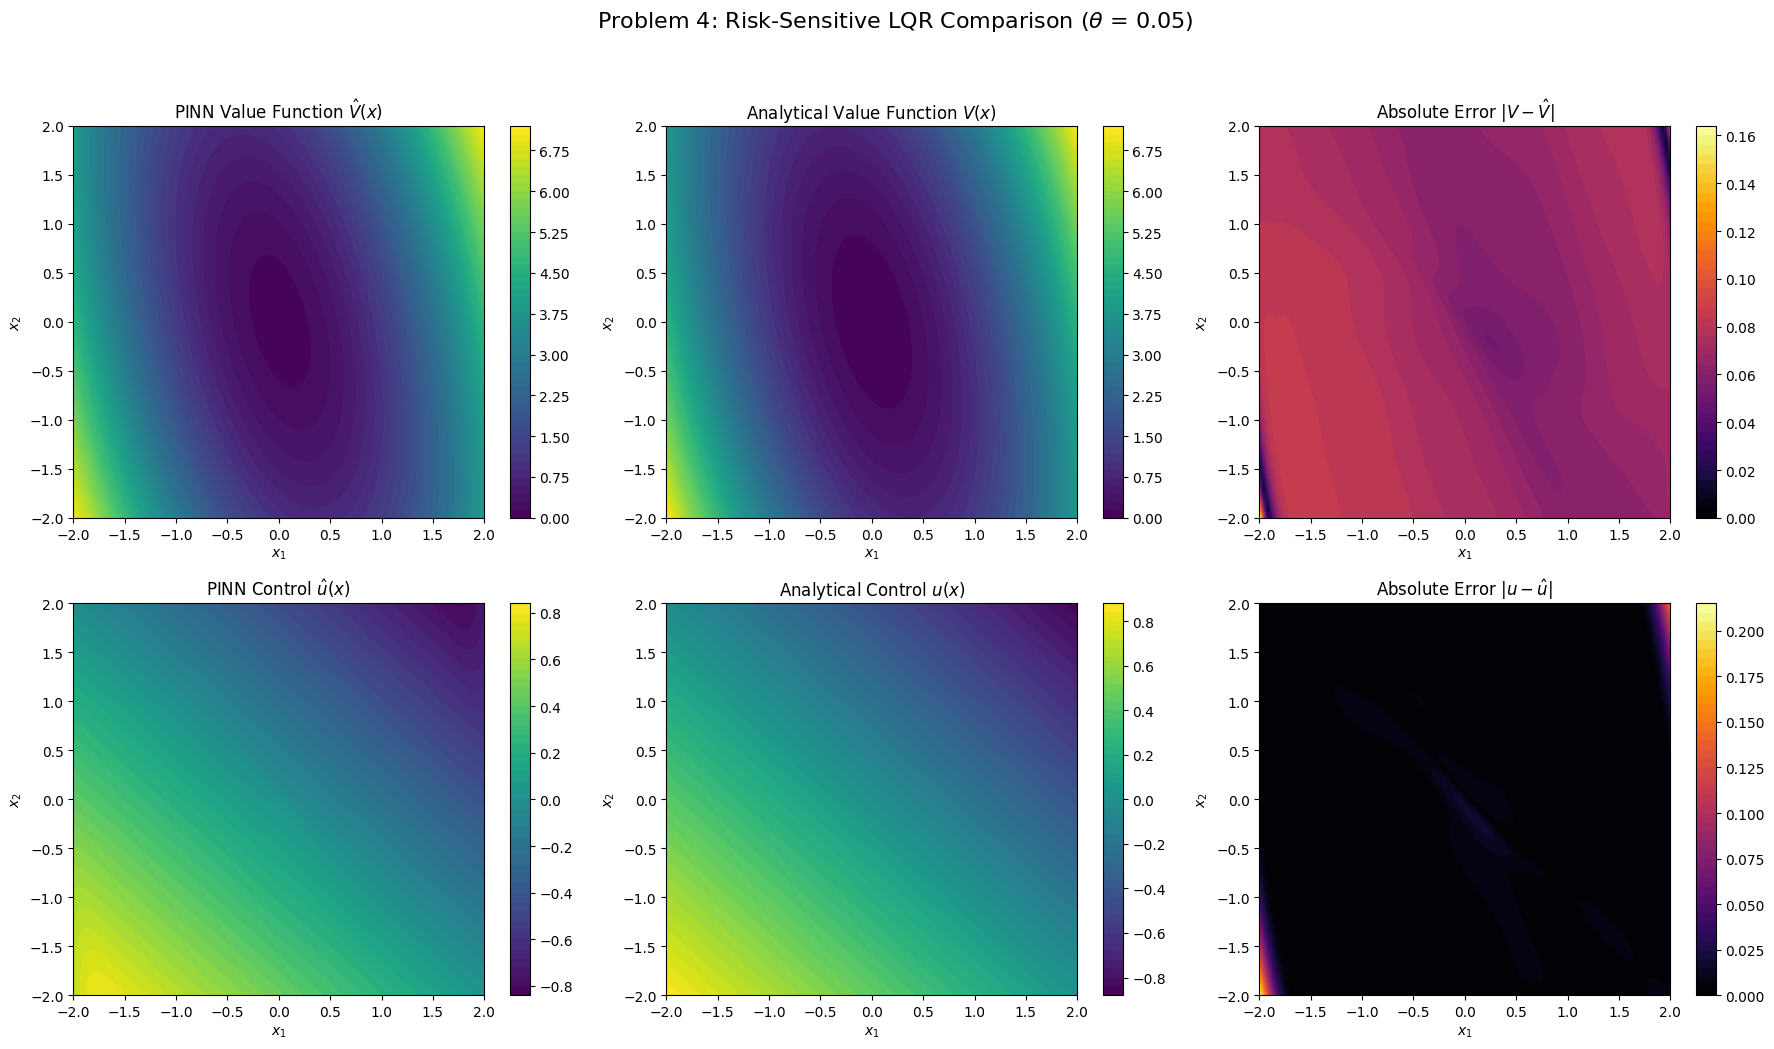


--- Running for theta = -0.01 ---
RSARE solver converged in 8 iterations for theta=-0.01.
Analytical P_theta matrix for theta=-0.01:
 [[1.14799602 0.21018732]
 [0.21018732 0.22457718]]
Problem 4 (theta=-0.01) - Epoch 0: Loss = 9.905126571655273
Problem 4 (theta=-0.01) - Epoch 1000: Loss = 0.004311292432248592
Problem 4 (theta=-0.01) - Epoch 2000: Loss = 0.00031027194927446544
Problem 4 (theta=-0.01) - Epoch 3000: Loss = 0.0001475278550060466
Problem 4 (theta=-0.01) - Epoch 4000: Loss = 5.097033135825768e-05

Problem 4 (theta=-0.01) - L1 Absolute Error (e1): 8.3390e-02
Problem 4 (theta=-0.01) - L1 Relative Error (e2): 3.0640e-01



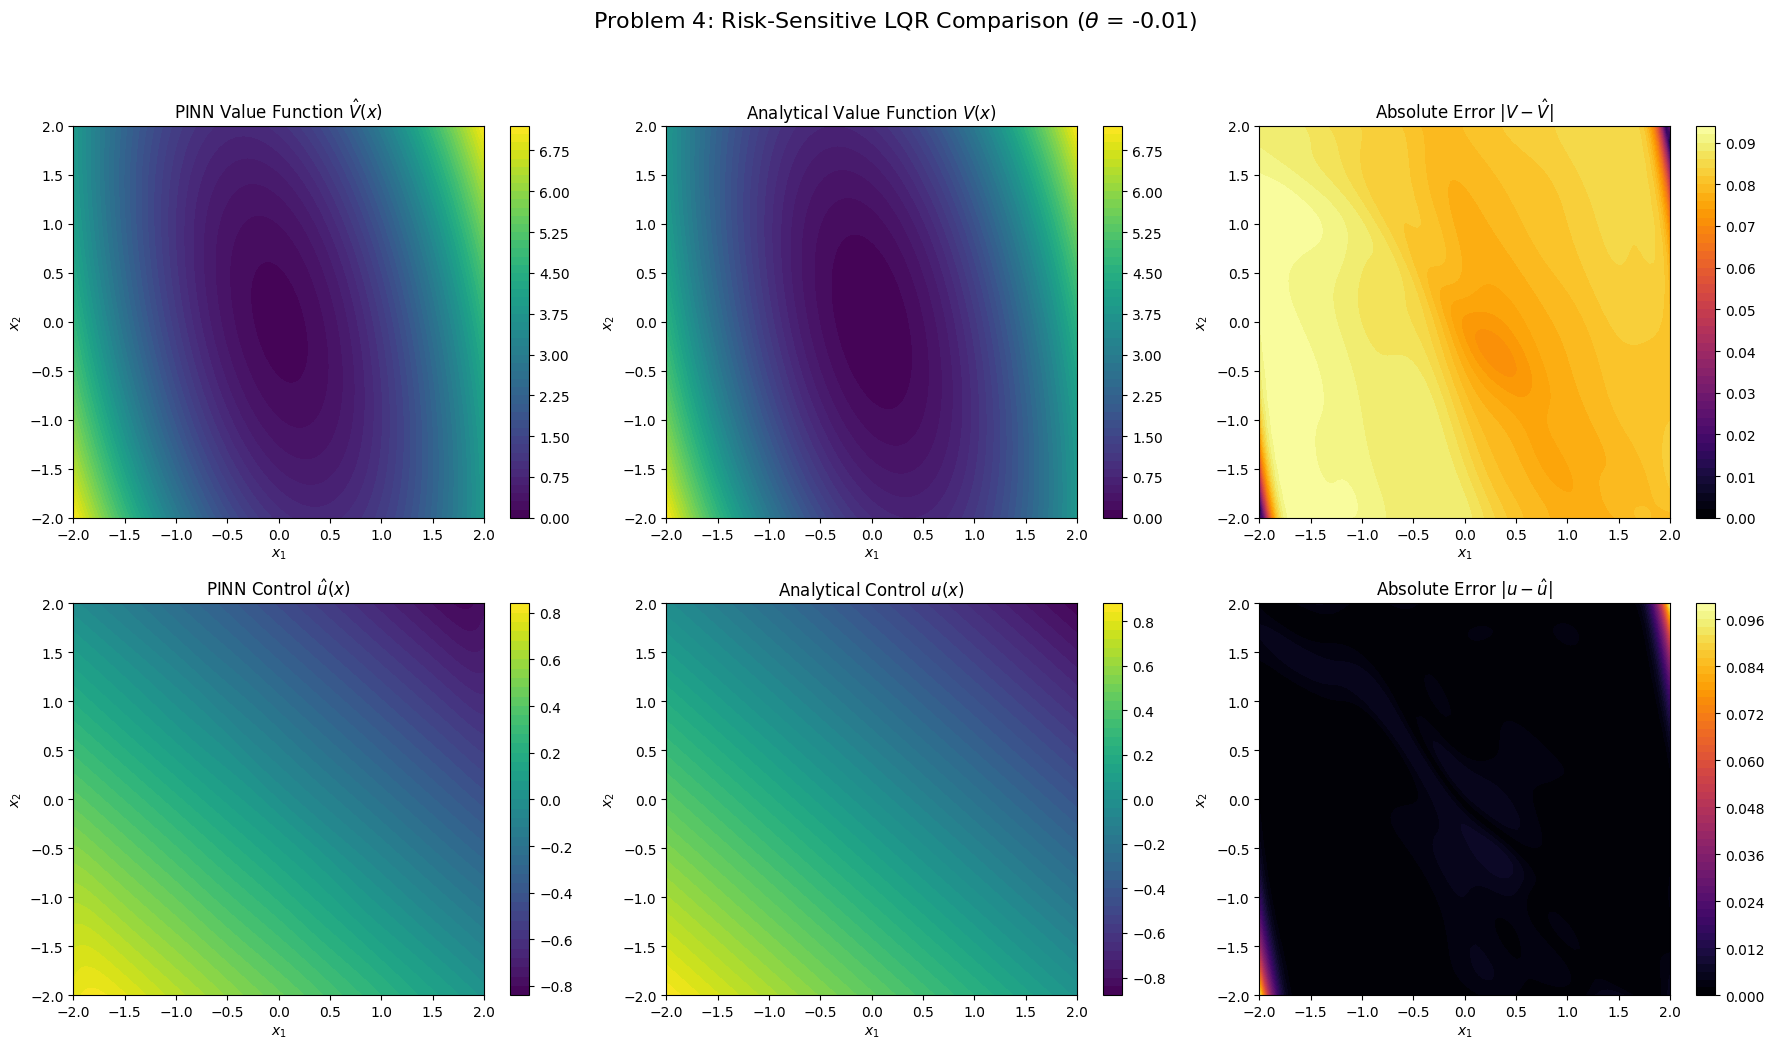

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float32
print(f"Using device: {DEVICE}")

# Common parameters
rho = 0.1
A = torch.tensor([[0., 1.], [-2., -3.]], dtype=DTYPE, device=DEVICE) 
B = torch.tensor([[0.], [1.]], dtype=DTYPE, device=DEVICE)
G = torch.tensor([[0.1, 0.], [0., 0.1]], dtype=DTYPE, device=DEVICE) 
Q = torch.tensor([[1., 0.], [0., 1.]], dtype=DTYPE, device=DEVICE) 
R = torch.tensor([[1.]], dtype=DTYPE, device=DEVICE) 
GG_T = G @ G.T

# PINN training parameters
N_train = 2000
learning_rate = 5e-3
epochs = 5000

# Helper function to compute the Hessian
def hessian(output, inputs):
    grad_output = torch.autograd.grad(outputs=output.sum(), inputs=inputs, create_graph=True)[0]
    hess = []
    for i in range(inputs.shape[1]):
        grad_of_grad_i = torch.autograd.grad(outputs=grad_output[:, i].sum(), inputs=inputs, create_graph=True)[0]
        hess.append(grad_of_grad_i)
    return torch.stack(hess, dim=2)

# PINN Model Definition
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# --- Problem 4: Risk-Sensitive LQR ---
print("--- Solving Problem 4: Risk-Sensitive LQR ---")

def solve_rsare_iteratively(theta, max_iters=100, tol=1e-8):
    """Solves the risk-sensitive algebraic Riccati equation."""
    A_np, B_np, Q_np, R_np = A.cpu().numpy(), B.cpu().numpy(), Q.cpu().numpy(), R.cpu().numpy()
    n = A_np.shape[0]
    R_inv_np = np.linalg.inv(R_np)
    GG_T_np = GG_T.cpu().numpy()
    
    P_k = solve_continuous_are(A_np, B_np, Q_np, R_np)
    A_lyap = A_np.T - (rho / 2.0) * np.eye(n)
    
    for i in range(max_iters):
        # This implementation uses the correct RSARE derived from the HJB equation (12)
        Q_tilde = -(Q_np - P_k @ B_np @ R_inv_np @ B_np.T @ P_k 
                      + theta * 2 * P_k @ GG_T_np @ P_k)
        
        P_k_plus_1 = solve_lyapunov(A_lyap, Q_tilde)
        
        if np.linalg.norm(P_k_plus_1 - P_k) < tol:
            print(f"RSARE solver converged in {i+1} iterations for theta={theta}.")
            return P_k_plus_1
        P_k = P_k_plus_1
    print("RSARE solver did not converge.")
    return P_k

def run_problem_4_for_theta(theta):
    print(f"\n--- Running for theta = {theta} ---")
    
    # (a) Analytical Solution
    P_analytical_4_np = solve_rsare_iteratively(theta)
    P_analytical_4 = torch.tensor(P_analytical_4_np, dtype=DTYPE, device=DEVICE)
    print(f"Analytical P_theta matrix for theta={theta}:\n", P_analytical_4_np)

    def V_analytical_4(x):
        return torch.einsum('bi,ij,bj->b', x, P_analytical_4, x)

    def u_analytical_4(x):
        K = torch.inverse(R) @ B.T @ P_analytical_4
        return -torch.einsum('ij,bj->b', K, x)

    # (b) PINN Method
    V_model_4 = ValueNetwork().to(DEVICE)
    optimizer_4 = torch.optim.Adam(V_model_4.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, patience=500, factor=0.5)

    for epoch in range(epochs):
        domain_points = torch.rand((N_train, 2), device=DEVICE) * 4 - 2
        domain_points.requires_grad = True
        optimizer_4.zero_grad()
        
        V = V_model_4(domain_points)
        grad_V = torch.autograd.grad(V.sum(), domain_points, create_graph=True)[0]
        hess_V = hessian(V, domain_points)
        gradV_Ax_term = torch.einsum('bi,bi->b', grad_V, domain_points @ A.T)

        hamiltonian = (torch.einsum('bi,ij,bj->b', domain_points, Q, domain_points)
                       - 0.25 * torch.einsum('bi,ij,bj->b', grad_V, B @ torch.inverse(R) @ B.T, grad_V)
                       + gradV_Ax_term
                       + 0.5 * torch.einsum('bii->b', GG_T @ hess_V))
        
        risk_term = theta * torch.einsum('bi,ij,bj->b', grad_V, GG_T, grad_V)
        f = rho * V.squeeze() - (hamiltonian + risk_term)
        loss = torch.mean(f**2)
        
        loss.backward()
        optimizer_4.step()
        scheduler.step(loss)
        
        if epoch % 1000 == 0:
            print(f"Problem 4 (theta={theta}) - Epoch {epoch}: Loss = {loss.item()}")

    # (c) Comparison
    xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    x_grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=DTYPE, device=DEVICE, requires_grad=True)

    # Calculate V and u for both analytical and PINN methods
    V_true = V_analytical_4(x_grid).detach().cpu().numpy()
    u_true = u_analytical_4(x_grid).detach().cpu().numpy()

    V_pinn_raw = V_model_4(x_grid)
    V_pinn = V_pinn_raw.detach().cpu().numpy().squeeze()
    
    grad_V_pinn = torch.autograd.grad(V_pinn_raw.sum(), x_grid)[0]
    u_pinn = 0.5 * (-torch.inverse(R) @ B.T @ grad_V_pinn.T).T.detach().cpu().numpy().squeeze()

    # Report L1 errors for V [cite: 115]
    error_v_abs = np.abs(V_pinn - V_true)
    error_v_rel = np.abs(V_pinn / V_true - 1.0)
    e1 = np.mean(error_v_abs)
    e2 = np.mean(error_v_rel)
    print(f"\nProblem 4 (theta={theta}) - L1 Absolute Error (e1): {e1:.4e}")
    print(f"Problem 4 (theta={theta}) - L1 Relative Error (e2): {e2:.4e}\n")

    # Generate Plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    fig.suptitle(rf'Problem 4: Risk-Sensitive LQR Comparison ($\theta$ = {theta})', fontsize=16)

    # --- Row 1: Value Function V(x) ---
    im1 = axes[0, 0].contourf(xx, yy, V_pinn.reshape(100, 100), 50, cmap='viridis')
    axes[0, 0].set_title(r'PINN Value Function $\hat{V}(x)$'); fig.colorbar(im1, ax=axes[0, 0])
    
    im2 = axes[0, 1].contourf(xx, yy, V_true.reshape(100, 100), 50, cmap='viridis')
    axes[0, 1].set_title(r'Analytical Value Function $V(x)$'); fig.colorbar(im2, ax=axes[0, 1])

    im3 = axes[0, 2].contourf(xx, yy, error_v_abs.reshape(100, 100), 50, cmap='inferno')
    axes[0, 2].set_title(r'Absolute Error $|V - \hat{V}|$'); fig.colorbar(im3, ax=axes[0, 2])
    
    # --- Row 2: Optimal Control u(x) ---
    im4 = axes[1, 0].contourf(xx, yy, u_pinn.reshape(100, 100), 50, cmap='viridis')
    axes[1, 0].set_title(r'PINN Control $\hat{u}(x)$'); fig.colorbar(im4, ax=axes[1, 0])
    
    im5 = axes[1, 1].contourf(xx, yy, u_true.reshape(100, 100), 50, cmap='viridis')
    axes[1, 1].set_title(r'Analytical Control $u(x)$'); fig.colorbar(im5, ax=axes[1, 1])

    error_u_abs = np.abs(u_pinn - u_true)
    im6 = axes[1, 2].contourf(xx, yy, error_u_abs.reshape(100, 100), 50, cmap='inferno')
    axes[1, 2].set_title(r'Absolute Error $|u - \hat{u}|$'); fig.colorbar(im6, ax=axes[1, 2])
    
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel(r'$x_1$'); ax.set_ylabel(r'$x_2$')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Run for both values of theta ---
run_problem_4_for_theta(theta=0.05)  # Risk-averse
run_problem_4_for_theta(theta=-0.01) # Risk-seeking